# Домашнее задание №1: Классификация. 
# Логистическая регрессия и kNN.

Форма для сдачи будет опубликована позднее.

### Пожалуйста, не производите никаких манипуляций с  переменной `_dict_for_submission` и с ячейками, в которых она используется. На ее основе будет сгенерирован итоговый файл для сдачи задания.

In [1]:
# Do not change me, just run
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
_dict_for_submission = dict()


def transform_list(list_of_ints):
    return [str(x) for x in list_of_ints]
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

### Часть 1. Небольшой numpy-разогрев. (10%)

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Создайте матрицу A размерами 10 на 10 из упорядоченных целых чисел от 0 до 100
# hint: np.arange(100).reshape((10, 10))

A = np.arange(100).reshape((10, 10))

In [4]:
# Посчитайте средние значения в матрице по столбцам

mean = np.mean(A, axis=0)

In [5]:
# Транспонируйте матрицу A

A_T = A.T

In [6]:
# Перемножьте поэлементно матрицу A и транспонированную матрицу A 

B = A * A_T

In [7]:
# Посчитайте matrix product (результат матричного умножения) матрицы A на саму себя и запишите в матрицу B
# https://en.wikipedia.org/wiki/Matrix_multiplication
# or https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html

B = A@A

#### Не меняйте следующую ячейку. Просто запустите ее.

In [8]:
# Do not change me, just run
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
_dict_for_submission['B'] = transform_list(list(B.flatten()))
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

### Часть 2. Логистическая регрессия и kNN.

Будем работать с подвыборкой из [данных о типе лесного покрытия из репозитория UCI](http://archive.ics.uci.edu/ml/datasets/Covertype). Доступно 7 различных классов. Каждый объект описывается 54 признаками, 40 из которых являются бинарными. Описание данных доступно по ссылке, а так же в файле `covtype.info.txt`.

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [10]:
all_data = pd.read_csv('forest_dataset.csv')
data_ = all_data[all_data.columns[:-1]]
labels_ = all_data[all_data.columns[-1]].values
scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(data_)
data_ = scaler.transform(data_)

Выделим 20% данных в `delayed_data` в качестве выборки, на которой будет производиться финальное сравнение моделей (до конца ноутбука она более не используется), в `all_data` поместим оставшиеся 80%. Не будем перемешивать данные сознательно (для удобства проверки).

In [11]:
delayed_feature_matrix = data_[int(0.8 * len(data_)):]
delayed_labels = labels_[int(0.8 * len(data_)):]

feature_matrix = data_[:int(0.8 * len(data_))]
labels = labels_[:int(0.8 * len(data_)):]


Выделим значения метки класса в переменную `labels`, признаковые описания в переменную `feature_matrix`. Так как данные числовые и не имеют пропусков, переведем их в `numpy`-формат с помощью метода `.values`.

In [12]:

#labels = all_data[all_data.columns[-1]]
#feature_matrix = all_data[all_data.columns[:-1]].values

#delayed_labels = delayed_data[delayed_data.columns[-1]].values
#delayed_feature_matrix = delayed_data[delayed_data.columns[:-1]].values

print(labels.shape, feature_matrix.shape)
print(delayed_labels.shape, delayed_feature_matrix.shape)

(8000,) (8000, 54)
(2000,) (2000, 54)


#### 2.1 Двуклассовая классификация (10%)

Для начала будем работать только с двумя типами лесного покрытия. Обучите линейный классификатор для разделения двух классов. Данные разделите на train и test с помощью `train_test_split`.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [14]:
two_class_labels_indices = (labels == 1) + (labels == 2)

two_class_feature_matrix = feature_matrix[two_class_labels_indices]
two_class_labels = labels[two_class_labels_indices]

In [15]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(two_class_feature_matrix,
                                                                                        two_class_labels,
                                                                                        test_size = 0.25,
                                                                                        random_state = 1)

Обучите логистическую регрессию. Оцените качество классификации на отложенной выборке с помощью `accuracy` и `f1_score` ([Wikipedia](https://en.wikipedia.org/wiki/F1_score)).

In [18]:
lr_clf = LogisticRegression(penalty='l1', solver='saga', n_jobs = -1, max_iter = 100000, tol = 1e-6, multi_class = 'auto')
lr_clf.fit(train_feature_matrix, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=1e-06, verbose=0,
                   warm_start=False)

In [19]:
prediction = lr_clf.predict(test_feature_matrix)
print ("accuracy score is: ",accuracy_score(test_labels, prediction), "\nf1 score: ", f1_score(test_labels, prediction))

accuracy score is:  0.7666277712952159 
f1 score:  0.7256515775034293


#### 2.2 Многоклассовая классификация: логистическая регрессия (40%)

**Комментарий:**

*Логистическая регрессия позволяет решать и задачу многоклассовой классификации. Класс ``LogisticRegression`` позвляет это делать двумя способами:* 
- *1. Стандартный One vs Rest (т.е. каждый класс отделяется от всех других). Параметр `multi_class='ovr'`.*
- *2. Используюя кросс-энтропию (оценивается сразу вектор вероятностей принадлежности классам). Параметр `multi_class='multinomial'`.*

*По умолчанию будем использовать второй способ.*


Теперь будем работать со всеми 7 типами покрытия (данные уже находятся в переменных `feature_matrix` и `labels`, если Вы их не переопределили). Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=42`. Обучите логистическую регрессию  на данном датасете.

In [20]:
train_feature_matrix_multi, test_feature_matrix_multi, train_labels_multi, test_labels_multi = train_test_split(feature_matrix,
                                                                                                                labels,
                                                                                                                test_size = 0.2,
                                                                                                                random_state = 42)

lr_clf = LogisticRegression(multi_class='multinomial', 
                            solver='saga', 
                            n_jobs = -1, 
                            tol = 1e-4, 
                            max_iter = 10000)

lr_clf.fit(feature_matrix, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `С` и `penalty`. Для параметра `C` используйте набор значений `np.linspace(0.01, 1, 10)`, а для `penalty` - `['l1', 'l2']`. Критерий качества `scoring = 'accuracy'`.

In [21]:
param_grid = {'C': np.exp(np.linspace(-3, 4, 15)), 'penalty': ['l1', 'l2']}
search_params = GridSearchCV(lr_clf, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1)
search_params.fit(feature_matrix, labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000,
                                          multi_class='multinomial', n_jobs=-1,
                                          penalty='l2', random_state=None,
                                          solver='saga', tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([4.97870684e-02, 8.20849986e-02, 1.35335283e-01, 2.23130160e-01,
       3.67879441e-01, 6.06530660e-01, 1.00000000e+00, 1.64872127e+00,
       2.71828183e+00, 4.48168907e+00, 7.38905610e+00, 1.21824940e+01,
       2.00855369e+01, 3.31154520e+01, 5.45981500e+01]),
                         'penalty': ['

In [24]:
import pandas
import matplotlib.pylab as plt
%matplotlib inline

df = pd.DataFrame(search_params.cv_results_)
datal1 = df[df.param_penalty == 'l1'][['param_C', 'mean_test_score']]
datal2 = df[df.param_penalty == 'l2'][['param_C', 'mean_test_score']]

Постройте графики средних значений критерия качества `accuracy` для типов регуляризации `l1` и `l2` в зависимости от коэффициента регуляризации `C`.

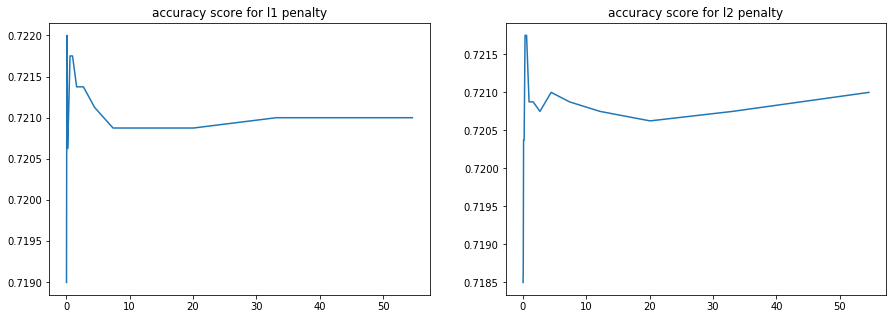

In [25]:
fig = plt.figure(figsize=(15, 5))
p = fig.add_subplot(1, 2, 1)
p.set_title('accuracy score for l1 penalty')
plt.plot(datal1['param_C'].values, datal1['mean_test_score'].values)
p = fig.add_subplot(1, 2, 2)
p.set_title('accuracy score for l2 penalty')
plt.plot(datal2['param_C'].values, datal2['mean_test_score'].values)

#### Проанализируйте полученные графики. Чему равны найденные оптимальные значения параметров `C` и `penalty`?

In [32]:
optimal_params = search_params.best_params_
print(optimal_params)
optimal_params = list(optimal_params.values())

{'C': 0.1353352832366127, 'penalty': 'l1'}
[0.1353352832366127, 'l1']


Используя найденные оптимальные значения `C` и `penalty`, обучите логистическую регрессию на обучающей выборке (train) и вычислите вероятности принадлежности к классам для тестовой (test)  выборки (`best_lr_clf.predict_proba`).

In [33]:
best_lr_clf = LogisticRegression(penalty = optimal_params[1], 
                                 tol = 1e-5, 
                                 C = optimal_params[0], 
                                 max_iter = 100000, 
                                 multi_class = 'multinomial', 
                                 solver = 'saga',
                                 n_jobs = -1)

best_lr_clf.fit(train_feature_matrix_multi, train_labels_multi)

LogisticRegression(C=0.1353352832366127, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100000, multi_class='multinomial', n_jobs=-1,
                   penalty='l1', random_state=None, solver='saga', tol=1e-05,
                   verbose=0, warm_start=False)

Для полученной матрицы вычислите усредненные по всем объектам из тестовой выборки значения вероятностей принадлежности к классам. Сравните ее оценкой вероятности принадлежности к классу на основе частот меток классов в обучающей выборке.

In [34]:
from collections import Counter

mean_predicted = np.mean(best_lr_clf.predict_proba(test_feature_matrix_multi), axis=0)
print('predicted: ', np.array(mean_predicted))

mean_real = np.array(list(Counter(test_labels_multi).values()))/len(test_labels_multi)
print('real: ', mean_real)

predicted:  [0.37324575 0.48769514 0.06201027 0.00548142 0.01637492 0.02749039
 0.0277021 ]
real:  [0.378125 0.478125 0.029375 0.06625  0.004375 0.03     0.01375 ]


#### 2.3 Многоклассовая классификация: kNN (30%).

Вспомним первое занятие. Обучите на том же датасете `KNeighborsClassifier` из `sklearn`.

In [35]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 6, weights = 'distance', algorithm = 'kd_tree', n_jobs = -1)
classifier.fit(feature_matrix, labels)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                     weights='distance')

Попробуйте использовать различные стратегии вычисления весов: `[‘uniform’, ‘distance’]`. Выберите одно из них самостоятельно. Чем обоснован Ваш выбор?

Переберите по сетке от `1` до `10` параметр числа соседей. Покажите на графике, как менялись значения критерия качества `accuracy` при изменении числа соседей.

In [36]:
param_grid = {'n_neighbors': np.linspace(1, 15, 15, dtype = int)}
search_params = GridSearchCV(classifier, param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1)
search_params.fit(feature_matrix, labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=6, p=2,
                                            weights='distance'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

{'n_neighbors': 4}


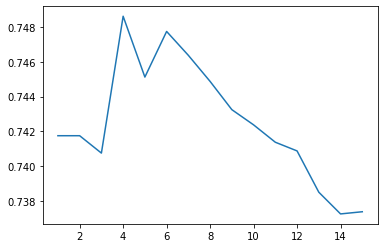

In [37]:
cv_results = search_params.cv_results_
print(search_params.best_params_)
plt.plot(cv_results['param_n_neighbors'], cv_results['mean_test_score'])

Используя найденное оптимальное число соседей, вычислите вероятности принадлежности к классам для тестовой выборки (`.predict_proba`).

In [41]:
knn_clf = KNeighborsClassifier(n_neighbors=list(search_params.best_params_.values())[0], weights='distance', algorithm = 'kd_tree', n_jobs = -1)
knn_clf.fit(train_feature_matrix_multi, train_labels_multi)
predicted_knn = knn_clf.predict_proba(test_feature_matrix_multi)

Создайте объект `best_knn_clf`, который представляет собой лучший классификатор.

In [42]:
# Hint: для этого достаточно указать стратегию вычисления весов и число соседей в конструкторе

best_knn_clf = KNeighborsClassifier(n_neighbors=list(search_params.best_params_.values())[0], weights='distance')
best_knn_clf.fit(train_feature_matrix_multi, train_labels_multi)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

#### 2.4 Сравнение результатов логистической регрессии и kNN (10%).

В реальной жизни новые данные становятся доступны с течением времени. Сравните качество Вашей лучшей модели логистической регресии `best_lr_clf` и лучшего kNN `best_knn_clf` на отложенной выборке `delayed_data`. Какая из моделей показала лучший результат?

In [43]:
print('lr:', best_lr_clf.score(delayed_feature_matrix, delayed_labels))
print('knn:', best_knn_clf.score(delayed_feature_matrix, delayed_labels))

lr: 0.7265
knn: 0.737


#### Не меняйте следующую ячейку. Запустите ее для генерации `submission` файла.

In [44]:
# Do not change me, just run
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
_dict_for_submission['best_lr_clf_delayed'] = transform_list(list(best_lr_clf.predict(delayed_feature_matrix)))
_dict_for_submission['best_knn_clf_delayed'] = transform_list(list(best_knn_clf.predict(delayed_feature_matrix)))

import json
with open('submission_hw1_basic.json', 'w') as iofile:
    json.dump(_dict_for_submission, iofile)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Данный файл необходимо будет прикрепить к Google-форме для сдачи домашнего задания. __Для идентификации используется e-mail, который вы указали при регистрации на курс. Проверка производится автоматически. Если вы подпишитесь другим e-mail'ом, задание просто не будет засчитано.__

На этом задание завершено. Мы будем рады, если вы оставите обратную связь по данному заданию [по ссылке](https://forms.gle/2qaf14ky3J6HZfe48). Она анонимна ;)